In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from enum import unique
from sklearn import preprocessing

c:\Users\Rodri\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
raw_df = pd.read_csv("https://raw.githubusercontent.com/rmarquez93/data_sources/main/imdb_top_1000.csv")

In [3]:
raw_df.shape

(1000, 16)

In [4]:
raw_df.head(5)

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


Goal: Predict the IMDB rating based on the rest of the features available.

Three features will be converted into continous numerical values. For these three variables a checking on the content that doesn't seem to be numerical is performed.

In [5]:
print("Variable: Released_Year")
print(raw_df[pd.to_numeric(raw_df["Released_Year"], errors='coerce').isnull()]["Released_Year"])
print("\n"+"*"*60)

print("Variable: Runtime")
print(raw_df[pd.to_numeric(raw_df["Runtime"], errors='coerce').isnull()]["Runtime"])
print("\n"+"*"*60)

print("Variable: Gross")
print(raw_df[pd.to_numeric(raw_df["Gross"], errors='coerce').isnull()]["Gross"])
print("\n"+"*"*60)

Variable: Released_Year
966    PG
Name: Released_Year, dtype: object

************************************************************
Variable: Runtime
0      142 min
1      175 min
2      152 min
3      202 min
4       96 min
        ...   
995    115 min
996    201 min
997    118 min
998     97 min
999     86 min
Name: Runtime, Length: 1000, dtype: object

************************************************************
Variable: Gross
0       28,341,469
1      134,966,411
2      534,858,444
3       57,300,000
4        4,360,000
          ...     
995            NaN
996            NaN
997     30,500,000
998            NaN
999            NaN
Name: Gross, Length: 1000, dtype: object

************************************************************


Deleting "mins" from the text of movie duration and converting it to integer later on. Converting to float the "gross" revenue too.

In [6]:
raw_df["Runtime"] = raw_df["Runtime"].str.replace("min","")
raw_df["Runtime"] = raw_df["Runtime"].str.strip()
raw_df["Runtime"] = raw_df["Runtime"].astype(int)
raw_df["Released_Year"] = raw_df["Released_Year"].replace("PG",np.nan)
#The variable is converted to float to handle null values. Null treatment will be done later on the script.
raw_df["Released_Year"] = raw_df["Released_Year"].astype(float) 
raw_df["Gross"] = raw_df["Gross"].str.replace(",","").astype(float)

# Exploratory Analysis

Overview of the data types that are shown in the dataframe.

In [7]:
for i in raw_df.columns:
  print(i," : ",raw_df[i].dtype)


Poster_Link  :  object
Series_Title  :  object
Released_Year  :  float64
Certificate  :  object
Runtime  :  int32
Genre  :  object
IMDB_Rating  :  float64
Overview  :  object
Meta_score  :  float64
Director  :  object
Star1  :  object
Star2  :  object
Star3  :  object
Star4  :  object
No_of_Votes  :  int64
Gross  :  float64


Null values general overview

In [8]:
raw_df.isnull().sum()

Poster_Link        0
Series_Title       0
Released_Year      1
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

In [9]:
raw_df.describe()

,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
count,999.000000,1000.000000,1000.000000,843.000000,1.000000e+03,8.310000e+02
mean,1991.217217,122.891000,7.949300,77.971530,2.736929e+05,6.803475e+07
std,23.297025,28.093671,0.275491,12.376099,3.273727e+05,1.097500e+08
min,1920.000000,45.000000,7.600000,28.000000,2.508800e+04,1.305000e+03
25%,1976.000000,103.000000,7.700000,70.000000,5.552625e+04,3.253559e+06
50%,1999.000000,119.000000,7.900000,79.000000,1.385485e+05,2.353089e+07
75%,2009.000000,137.000000,8.100000,87.000000,3.741612e+05,8.075089e+07
max,2020.000000,321.000000,9.300000,100.000000,2.343110e+06,9.366622e+08


In the following cell, an iteration will be performed with the purpose of obtaining a first level statistics information about the features.

After gathering the first-level statistics, if the feature is of type 'float' or 'int', the function 'freq_table' is called to obtain information on symmetry, kurtosis, and Spearman coefficient.

count                                                  1000
unique                                                 1000
top       https://m.media-amazon.com/images/M/MV5BMDFkYT...
freq                                                      1
Name: Poster_Link, dtype: object 
--------------------------------

count         1000
unique         999
top       Drishyam
freq             2
Name: Series_Title, dtype: object 
--------------------------------



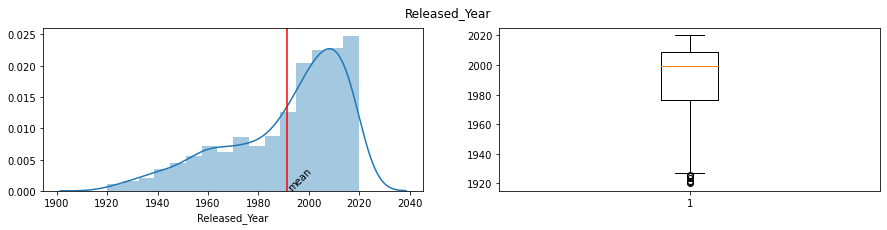

Asimetría: -0.939346641352243
Curtosis: -0.021431891218695487
count     999.000000
mean     1991.217217
std        23.297025
min      1920.000000
25%      1976.000000
50%      1999.000000
75%      2009.000000
max      2020.000000
Name: Released_Year, dtype: float64 
Coeficiente de variación de Pearson: 0.011699891223762344 
--------------------------------

count     899
unique     16
top         U
freq      234
Name: Certificate, dtype: object 
--------------------------------

count    1000.000000
mean      122.891000
std        28.093671
min        45.000000
25%       103.000000
50%       119.000000
75%       137.000000
max       321.000000
Name: Runtime, dtype: float64 
--------------------------------

count      1000
unique      202
top       Drama
freq         85
Name: Genre, dtype: object 
--------------------------------



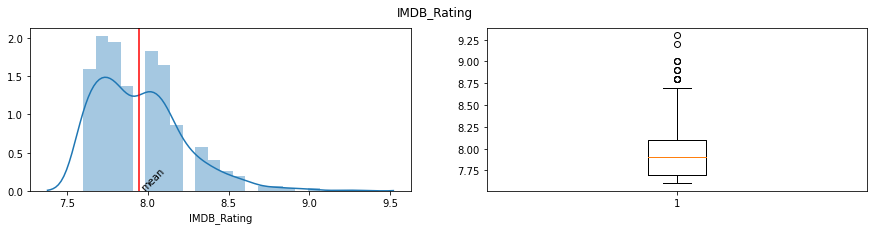

Asimetría: 1.016964453611272
Curtosis: 1.4327269987500322
count    1000.000000
mean        7.949300
std         0.275491
min         7.600000
25%         7.700000
50%         7.900000
75%         8.100000
max         9.300000
Name: IMDB_Rating, dtype: float64 
Coeficiente de variación de Pearson: 0.03465603354911869 
--------------------------------

count                                                  1000
unique                                                 1000
top       Two imprisoned men bond over a number of years...
freq                                                      1
Name: Overview, dtype: object 
--------------------------------



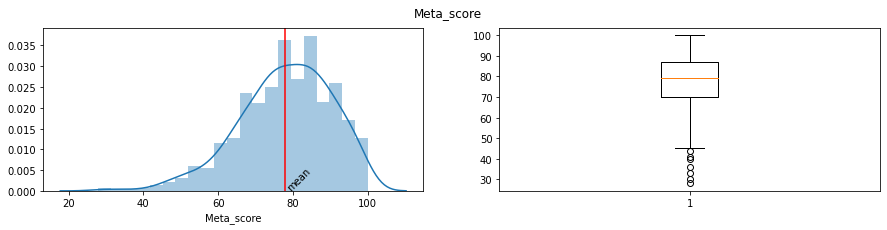

Asimetría: -0.6052248305009935
Curtosis: 0.4208306168018683
count    843.000000
mean      77.971530
std       12.376099
min       28.000000
25%       70.000000
50%       79.000000
75%       87.000000
max      100.000000
Name: Meta_score, dtype: float64 
Coeficiente de variación de Pearson: 0.15872587454756587 
--------------------------------

count                 1000
unique                 548
top       Alfred Hitchcock
freq                    14
Name: Director, dtype: object 
--------------------------------

count          1000
unique          660
top       Tom Hanks
freq             12
Name: Star1, dtype: object 
--------------------------------

count            1000
unique            841
top       Emma Watson
freq                7
Name: Star2, dtype: object 
--------------------------------

count             1000
unique             891
top       Rupert Grint
freq                 5
Name: Star3, dtype: object 
--------------------------------

count              1000
unique     

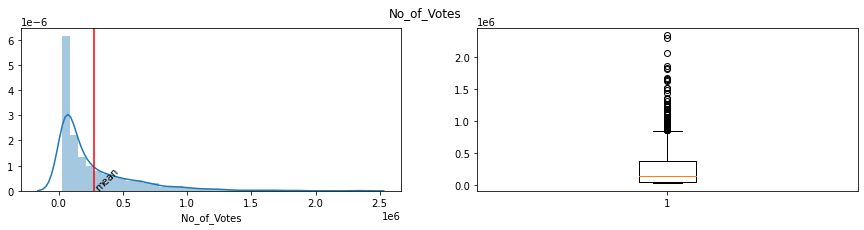

Asimetría: 2.30001058546554
Curtosis: 6.89509932739565
count    1.000000e+03
mean     2.736929e+05
std      3.273727e+05
min      2.508800e+04
25%      5.552625e+04
50%      1.385485e+05
75%      3.741612e+05
max      2.343110e+06
Name: No_of_Votes, dtype: float64 
Coeficiente de variación de Pearson: 1.1961314698944645 
--------------------------------



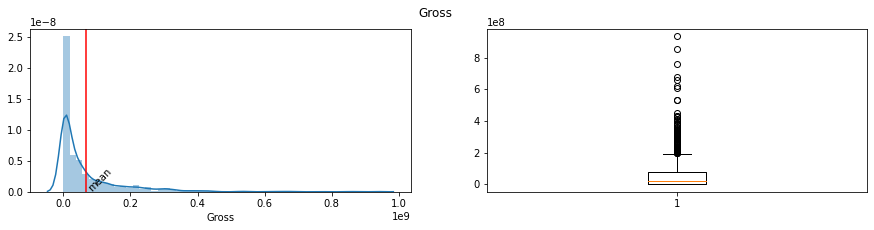

Asimetría: 3.1301343288134538
Curtosis: 13.914472951089826
count    8.310000e+02
mean     6.803475e+07
std      1.097500e+08
min      1.305000e+03
25%      3.253559e+06
50%      2.353089e+07
75%      8.075089e+07
max      9.366622e+08
Name: Gross, dtype: float64 
Coeficiente de variación de Pearson: 1.6131468372098896 
--------------------------------



In [10]:
for columnName in raw_df.columns:
  
  if (raw_df[columnName].dtype == np.float64 or raw_df[columnName].dtype == np.int64) and raw_df[columnName].isnull().sum() != len(raw_df[columnName]):
    plt.figure(figsize = (15,3))
    plt.suptitle(columnName)
    plt.subplot(1,2,1)
    sns.distplot(raw_df[columnName])
    plt.axvline(raw_df[columnName].mean(), color= "red")
    plt.text(raw_df[columnName].mean(),0,'mean',rotation=45)
    plt.subplot(1,2,2)
    plt.boxplot(raw_df[~np.isnan(raw_df[columnName])][columnName]) 
    plt.show()
    print("Asimetría: {}".format(raw_df[columnName].skew()))
    print("Curtosis: {}".format(raw_df[columnName].kurt()))
    spearman = raw_df[columnName].std()/raw_df[columnName].mean()
    print(raw_df[columnName].describe(),"\nCoeficiente de variación de Pearson: {} \n--------------------------------\n".format(spearman))
  else:
    print(raw_df[columnName].describe(),"\n--------------------------------\n")

As a first step, I will review the content of the "Certificate" feature. This feature represents the qualifications that movies receive for their public exhibition.

In [11]:
raw_df["Certificate"].unique()

array(['A', 'UA', 'U', 'PG-13', 'R', nan, 'PG', 'G', 'Passed', 'TV-14',
       '16', 'TV-MA', 'Unrated', 'GP', 'Approved', 'TV-PG', 'U/A'],
      dtype=object)

The values "U," "U/A," "A," and "S" correspond to the certification provided by the Central Board of Film Certification of the Indian government. Additionally, the values "G," "PG," and "R" are from the Motion Picture Association of the United States, which is the most widely recognized globally. Lastly, the value "TV-PG" corresponds to the Federal Communications Commission of the United States and applies to content broadcasted on TV.

Based on the above, I will take two actions: first, I will convert all the values to a single scale (that of the MPAA), and secondly, I will handle those values that do not fit into any of the mentioned scales.

| CBFC | MPAA Movies | MPAA TV | Description |
| - | - | - | - |
| U | G, PG | TV-Y, TV-Y7, TV-G, TV-PG | Unrestricted public exhibition, suitable for all ages |
| UA | PG-13 | TV-14 | Unrestricted public exhibition but with caution to give parental guidance for under 12 |
| A | R, NC-17 | TV-MA | Only adults are allowed to view these programs |


In [12]:
raw_df[~raw_df["Certificate"].isin(["G","PG","PG-13","R"])]["Certificate"].unique()

array(['A', 'UA', 'U', nan, 'Passed', 'TV-14', '16', 'TV-MA', 'Unrated',
       'GP', 'Approved', 'TV-PG', 'U/A'], dtype=object)

In [13]:
raw_df["Certificate"] = raw_df["Certificate"].str.replace("/","").replace("GP","PG")

mapping = {"A":"R","UA":"PG-13","U":"G", "TV-PG":"G", "TV-14":"PG-13", "TV-MA":"R"}

raw_df = raw_df.replace({"Certificate":mapping})

raw_df[~raw_df["Certificate"].isin(["G","PG","PG-13","R"])]["Certificate"].unique()

array([nan, 'Passed', '16', 'Unrated', 'Approved'], dtype=object)

I assume that "Passed" or "Approved" means they have the most suitable certification for all audiences (G).

In [14]:
raw_df = raw_df.replace({"Certificate":{"Passed":"G", "Approved":"G"}})

raw_df["Certificate"].unique()

array(['R', 'PG-13', 'G', nan, 'PG', '16', 'Unrated'], dtype=object)

Converting those values that cannot be easily allocated to "null".

In [15]:
raw_df["Certificate"] = raw_df["Certificate"].replace("16", np.nan).replace("Unrated",np.nan)

In [16]:
raw_df["Certificate"].unique()

array(['R', 'PG-13', 'G', nan, 'PG'], dtype=object)

Encoding the categories to a numeric value. This categories are ordinal, as it goes from "widest audience" to "most restricted audience".

In [17]:
raw_df = raw_df.replace({"Certificate":{
    "G":1,
    "PG":1,
    "PG-13":2,
    "R":3
}})

# Missing values analysis:

General overview.

In [18]:
raw_df.isnull().sum()

Poster_Link        0
Series_Title       0
Released_Year      1
Certificate      103
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

First, I remove the null value in Released_Year because it is just one record.

In [19]:
raw_df = raw_df[~pd.isnull(raw_df["Released_Year"])].copy()

Creating a "decade" column to make certain analysis easier.

In [20]:
raw_df["Released_Decade"] = (10*(raw_df.Released_Year//10))

Distribution of movies throughout the decades.

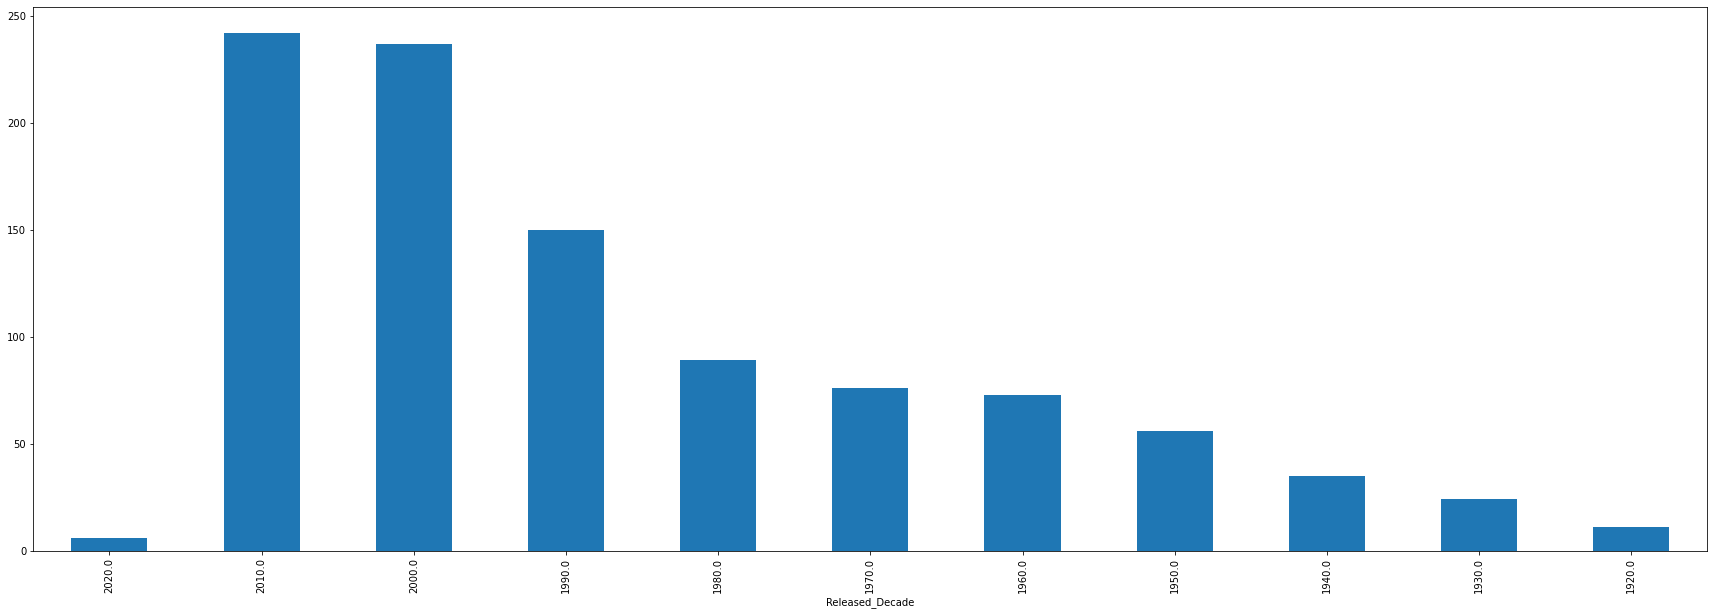

In [21]:
plt.figure(figsize = (30,10))
raw_df.Released_Decade.value_counts().sort_index(ascending=False).plot(kind = "bar")

In the case of gross, there are 169 missing records out of a total of 1000 records. We will attempt to identify any patterns in which these records are missing (e.g., by year/decade) to determine the treatment to be applied to this data.

<BarContainer object of 11 artists>

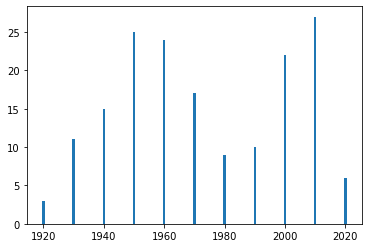

In [22]:
nulls_by_decade = raw_df[pd.isnull(raw_df["Gross"])].groupby(["Released_Decade"])["Released_Decade"].count().to_frame()
nulls_by_decade.rename(columns={"Released_Decade":"Occurrences"}, inplace=True)
nulls_by_decade.reset_index(inplace=True)
nulls_by_decade
plt.bar(nulls_by_decade["Released_Decade"], nulls_by_decade["Occurrences"])

At first glance, there doesn't appear to be any particular pattern or specific decade where revenue information is missing. The next step will be to impute the missing values based on the Meta_score variable. To do this, I remove records that have missing values in both variables simultaneously.

In [23]:
raw_df = raw_df[~((pd.isnull(raw_df["Meta_score"]))&(pd.isnull(raw_df["Gross"])))].copy()

After splittinh the vaules based on Meta_score, no simple patter can be analyzed. Given that, I will delete the "Gross" missing values.

,Meta_score,Occurrences
0,51,1
1,58,1
2,59,1
3,60,1
4,62,1


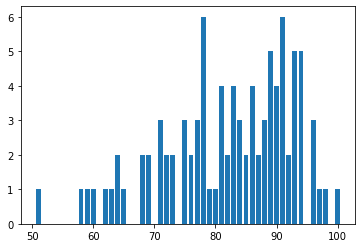

In [24]:
nulls_by_Meta_score = raw_df.loc[pd.isnull(raw_df["Gross"]),["Meta_score","Gross"]].copy() #pd.isnull(raw_df["Gross"])
nulls_by_Meta_score["Meta_score"] = nulls_by_Meta_score["Meta_score"].astype("int") 
nulls_by_Meta_score = nulls_by_Meta_score[pd.isnull(nulls_by_Meta_score["Gross"])].groupby("Meta_score")["Meta_score"].count().to_frame().copy()
nulls_by_Meta_score.rename(columns={"Meta_score":"Occurrences"}, inplace=True)
nulls_by_Meta_score.reset_index(inplace=True)
plt.bar(nulls_by_Meta_score["Meta_score"], nulls_by_Meta_score["Occurrences"])
nulls_by_Meta_score.head()

In [25]:
raw_df = raw_df.loc[~pd.isnull(raw_df["Gross"])].copy()

Metascore missing values will also be deleted.

In [26]:
raw_df = raw_df.loc[~pd.isnull(raw_df["Meta_score"])].copy()

For the "Certificate" feature, the mode will be imputed.

In [27]:
raw_df.loc[pd.isnull(raw_df["Certificate"]),"Certificate"] = raw_df["Certificate"].mode().values[0]

# Outliers analysis

Gross is converted to logarithmic scale to minimize the impact of outliers in the data. Although outliers still exist, the models that will be created are robust to the presence of outliers, so no further analysis is performed.

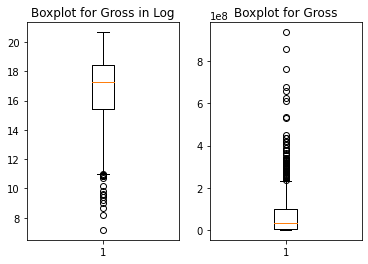

In [28]:
raw_df["Gross_Log"] = np.log(raw_df["Gross"])
raw_df["Gross_Log"]
plt.subplot(1,2,1)
plt.title("Boxplot for Gross in Log")
plt.boxplot(raw_df[~np.isnan(raw_df["Gross_Log"])]["Gross_Log"])
plt.subplot(1,2,2)
plt.title("Boxplot for Gross")
plt.boxplot(raw_df[~np.isnan(raw_df["Gross"])]["Gross"])
plt.show()

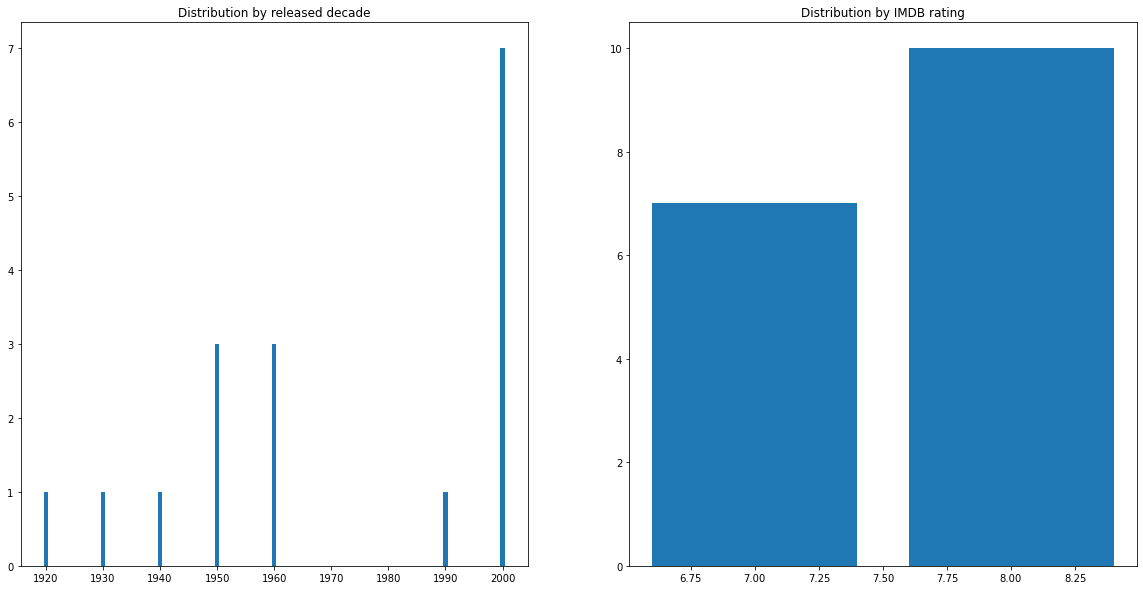

In [29]:
#IQR Calculation
Q3 = raw_df["Gross_Log"].quantile(0.75)
Q1 = raw_df["Gross_Log"].quantile(0.25)
IQR = Q3-Q1


outliers_df = raw_df.loc[raw_df["Gross_Log"]<= (Q1-IQR*1.5),["Released_Decade","IMDB_Rating","Gross_Log"]]
outliers_df["IMDB_Rating"] = outliers_df["IMDB_Rating"].astype("int")
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.title("Distribution by released decade")
plt.bar(outliers_df["Released_Decade"].value_counts().index,outliers_df["Released_Decade"].value_counts())
plt.subplot(1,2,2)
plt.title("Distribution by IMDB rating")
plt.bar(outliers_df["IMDB_Rating"].value_counts().index,outliers_df["IMDB_Rating"].value_counts())
plt.show()

In [30]:
outliers_df["Released_Decade"].value_counts()

Released_Decade
2000.0    7
1950.0    3
1960.0    3
1930.0    1
1940.0    1
1920.0    1
1990.0    1
Name: count, dtype: int64

# Feature selection

Correlation map.

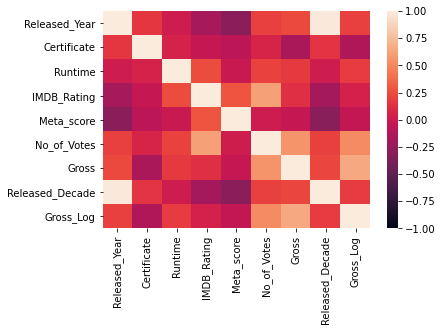

In [31]:
import seaborn as sns 

correlation_df = raw_df.corr(numeric_only = True)
sns.heatmap(correlation_df, vmin =-1, vmax=1)

In [32]:
correlation_df

,Released_Year,Certificate,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross,Released_Decade,Gross_Log
Released_Year,1.000000,0.159093,0.012976,-0.179065,-0.306421,0.203316,0.235951,0.989307,0.196986
Certificate,0.159093,1.000000,0.061536,-0.028670,-0.077583,0.064129,-0.158766,0.154782,-0.136928
Runtime,0.012976,0.061536,1.000000,0.257201,-0.012183,0.217457,0.172226,0.015252,0.186551
IMDB_Rating,-0.179065,-0.028670,0.257201,1.000000,0.282887,0.614358,0.129378,-0.180614,0.054289
Meta_score,-0.306421,-0.077583,-0.012183,0.282887,1.000000,0.010298,-0.030560,-0.311281,-0.046095
No_of_Votes,0.203316,0.064129,0.217457,0.614358,0.010298,1.000000,0.556003,0.205357,0.516635
Gross,0.235951,-0.158766,0.172226,0.129378,-0.030560,0.556003,1.000000,0.228970,0.651276
Released_Decade,0.989307,0.154782,0.015252,-0.180614,-0.311281,0.205357,0.228970,1.000000,0.185350
Gross_Log,0.196986,-0.136928,0.186551,0.054289,-0.046095,0.516635,0.651276,0.185350,1.000000


For the correlations analysis, a threshold of |0.70| is considered as OK. When this threshold is surpassed, the variables will be analyzed in order to delete that correlation and avoid multicollinearity.

With that rule taken into consideration, the only variable deleted will be "Gross", as "Gross_Log" is a transformation of that feature.

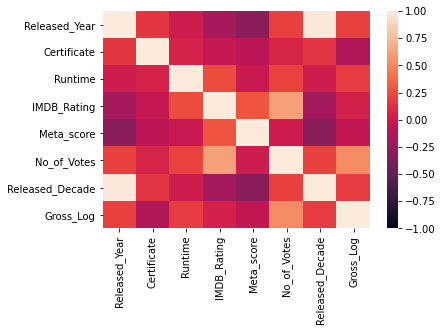

In [33]:
correlation_df = raw_df.drop(["Gross"], axis=1).corr(numeric_only = True)
sns.heatmap(correlation_df, vmin =-1, vmax=1)

In [34]:
correlation_df

,Released_Year,Certificate,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Released_Decade,Gross_Log
Released_Year,1.000000,0.159093,0.012976,-0.179065,-0.306421,0.203316,0.989307,0.196986
Certificate,0.159093,1.000000,0.061536,-0.028670,-0.077583,0.064129,0.154782,-0.136928
Runtime,0.012976,0.061536,1.000000,0.257201,-0.012183,0.217457,0.015252,0.186551
IMDB_Rating,-0.179065,-0.028670,0.257201,1.000000,0.282887,0.614358,-0.180614,0.054289
Meta_score,-0.306421,-0.077583,-0.012183,0.282887,1.000000,0.010298,-0.311281,-0.046095
No_of_Votes,0.203316,0.064129,0.217457,0.614358,0.010298,1.000000,0.205357,0.516635
Released_Decade,0.989307,0.154782,0.015252,-0.180614,-0.311281,0.205357,1.000000,0.185350
Gross_Log,0.196986,-0.136928,0.186551,0.054289,-0.046095,0.516635,0.185350,1.000000


The next step is to create the "Processed_df" keeping only those variables that will be used in the models. For that, I will delete not only "Gross", but also "Poster_Link" and "Series_Title".

In [35]:
processed_df = raw_df.drop([ "Gross",  "Poster_Link", "Series_Title"], axis=1).copy() 
processed_df

,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Released_Decade,Gross_Log
0,1994.0,3.0,142,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,1990.0,17.159837
1,1972.0,3.0,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,1970.0,18.720536
2,2008.0,2.0,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,2000.0,20.097513
3,1974.0,3.0,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,1970.0,17.863811
4,1957.0,1.0,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,1950.0,15.287983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,1971.0,1.0,157,"Drama, War, Western",7.6,A low-life bandit and an I.R.A. explosives exp...,77.0,Sergio Leone,Rod Steiger,James Coburn,Romolo Valli,Maria Monti,30144,1970.0,13.454096
991,1970.0,1.0,144,"Adventure, Comedy, War",7.6,A group of U.S. soldiers sneaks across enemy l...,50.0,Brian G. Hutton,Clint Eastwood,Telly Savalas,Don Rickles,Carroll O'Connor,45338,1970.0,14.136459
992,1967.0,1.0,78,"Animation, Adventure, Family",7.6,Bagheera the Panther and Baloo the Bear have a...,65.0,Wolfgang Reitherman,Phil Harris,Sebastian Cabot,Louis Prima,Bruce Reitherman,166409,1960.0,18.770236
994,1964.0,1.0,87,"Comedy, Music, Musical",7.6,"Over two ""typical"" days in the life of The Bea...",96.0,Richard Lester,John Lennon,Paul McCartney,George Harrison,Ringo Starr,40351,1960.0,16.438731


For the dummy variables generation, I will keep only the first Genre assigned for each movie.

In [36]:
processed_df["Genre"] = processed_df.apply(lambda row: row["Genre"].split(",")[0], axis=1)

Creating a feature "Director Level" to categorize the directors based on their movies' metacritic average. 4 buckets will be created, being 1 the best and 4 the worst.

In [37]:
directors = raw_df.groupby("Director")["Meta_score"].mean().to_frame()
directors = pd.qcut(directors["Meta_score"], q=4, labels=[4,3,2,1]).to_frame()

processed_df["Director"] = processed_df["Director"].map(directors["Meta_score"])
processed_df


,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Released_Decade,Gross_Log
0,1994.0,3.0,142,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,3,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,1990.0,17.159837
1,1972.0,3.0,175,Crime,9.2,An organized crime dynasty's aging patriarch t...,100.0,1,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,1970.0,18.720536
2,2008.0,2.0,152,Action,9.0,When the menace known as the Joker wreaks havo...,84.0,3,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,2000.0,20.097513
3,1974.0,3.0,202,Crime,9.0,The early life and career of Vito Corleone in ...,90.0,1,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,1970.0,17.863811
4,1957.0,1.0,96,Crime,9.0,A jury holdout attempts to prevent a miscarria...,96.0,1,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,1950.0,15.287983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,1971.0,1.0,157,Drama,7.6,A low-life bandit and an I.R.A. explosives exp...,77.0,3,Rod Steiger,James Coburn,Romolo Valli,Maria Monti,30144,1970.0,13.454096
991,1970.0,1.0,144,Adventure,7.6,A group of U.S. soldiers sneaks across enemy l...,50.0,4,Clint Eastwood,Telly Savalas,Don Rickles,Carroll O'Connor,45338,1970.0,14.136459
992,1967.0,1.0,78,Animation,7.6,Bagheera the Panther and Baloo the Bear have a...,65.0,4,Phil Harris,Sebastian Cabot,Louis Prima,Bruce Reitherman,166409,1960.0,18.770236
994,1964.0,1.0,87,Comedy,7.6,"Over two ""typical"" days in the life of The Bea...",96.0,1,John Lennon,Paul McCartney,George Harrison,Ringo Starr,40351,1960.0,16.438731


Performing a similar approach for the movie stars. The main difference for this case is that first of all I will create a list of unique actors and then apply their average metacritic score.

In [38]:
full_list = pd.concat([processed_df['Star1'], processed_df['Star2'],
                         processed_df['Star3'],  processed_df['Star4']])

full_list = full_list.unique().tolist()

full_list = pd.DataFrame(columns= ["Actor"], data=full_list)

for i, c in full_list.iterrows(): 
    full_list.loc[i,"Score"] = raw_df[(raw_df["Star1"] == full_list.loc[i,"Actor"] )|
                                      (raw_df["Star2"] == full_list.loc[i,"Actor"] )|
                                      (raw_df["Star3"] == full_list.loc[i,"Actor"] )|
                                      (raw_df["Star4"] == full_list.loc[i,"Actor"] )]["Meta_score"].mean()

full_list["Ranking"] = pd.qcut(full_list["Score"], q=4, labels=[4,3,2,1])

full_list.set_index("Actor", inplace=True)

processed_df["Star1"] = processed_df["Star1"].map(full_list["Ranking"])
processed_df["Star2"] = processed_df["Star2"].map(full_list["Ranking"])
processed_df["Star3"] = processed_df["Star3"].map(full_list["Ranking"])
processed_df["Star4"] = processed_df["Star4"].map(full_list["Ranking"])

processed_df

,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Released_Decade,Gross_Log
0,1994.0,3.0,142,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,3,2,3,2,2,2343110,1990.0,17.159837
1,1972.0,3.0,175,Crime,9.2,An organized crime dynasty's aging patriarch t...,100.0,1,1,2,1,2,1620367,1970.0,18.720536
2,2008.0,2.0,152,Action,9.0,When the menace known as the Joker wreaks havo...,84.0,3,3,2,2,3,2303232,2000.0,20.097513
3,1974.0,3.0,202,Crime,9.0,The early life and career of Vito Corleone in ...,90.0,1,2,2,2,2,1129952,1970.0,17.863811
4,1957.0,1.0,96,Crime,9.0,A jury holdout attempts to prevent a miscarria...,96.0,1,2,1,1,1,689845,1950.0,15.287983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,1971.0,1.0,157,Drama,7.6,A low-life bandit and an I.R.A. explosives exp...,77.0,3,3,2,3,3,30144,1970.0,13.454096
991,1970.0,1.0,144,Adventure,7.6,A group of U.S. soldiers sneaks across enemy l...,50.0,4,3,4,3,4,45338,1970.0,14.136459
992,1967.0,1.0,78,Animation,7.6,Bagheera the Panther and Baloo the Bear have a...,65.0,4,4,4,4,4,166409,1960.0,18.770236
994,1964.0,1.0,87,Comedy,7.6,"Over two ""typical"" days in the life of The Bea...",96.0,1,1,1,1,1,40351,1960.0,16.438731


In [39]:
#Dummy variables DF generated

obj=['Genre']
dummy_vars = pd.get_dummies(processed_df[obj],drop_first=True)

dummy_vars.head(5)

,Genre_Adventure,Genre_Animation,Genre_Biography,Genre_Comedy,Genre_Crime,Genre_Drama,Genre_Family,Genre_Film-Noir,Genre_Horror,Genre_Mystery,Genre_Thriller,Genre_Western
0,False,False,False,False,False,True,False,False,False,False,False,False
1,False,False,False,False,True,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,False,False


Concatenation of processed_df and the dumm_vars dataframes.

In [40]:
processed_final = pd.concat([processed_df[["Runtime","IMDB_Rating","Certificate",
 "Released_Year","Director","Star1","Star2","Star3","Star4","No_of_Votes","Meta_score","Gross_Log"]], 
                             dummy_vars], axis=1)
processed_final

,Runtime,IMDB_Rating,Certificate,Released_Year,Director,Star1,Star2,Star3,Star4,No_of_Votes,...,Genre_Biography,Genre_Comedy,Genre_Crime,Genre_Drama,Genre_Family,Genre_Film-Noir,Genre_Horror,Genre_Mystery,Genre_Thriller,Genre_Western
0,142,9.3,3.0,1994.0,3,2,3,2,2,2343110,...,False,False,False,True,False,False,False,False,False,False
1,175,9.2,3.0,1972.0,1,1,2,1,2,1620367,...,False,False,True,False,False,False,False,False,False,False
2,152,9.0,2.0,2008.0,3,3,2,2,3,2303232,...,False,False,False,False,False,False,False,False,False,False
3,202,9.0,3.0,1974.0,1,2,2,2,2,1129952,...,False,False,True,False,False,False,False,False,False,False
4,96,9.0,1.0,1957.0,1,2,1,1,1,689845,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,157,7.6,1.0,1971.0,3,3,2,3,3,30144,...,False,False,False,True,False,False,False,False,False,False
991,144,7.6,1.0,1970.0,4,3,4,3,4,45338,...,False,False,False,False,False,False,False,False,False,False
992,78,7.6,1.0,1967.0,4,4,4,4,4,166409,...,False,False,False,False,False,False,False,False,False,False
994,87,7.6,1.0,1964.0,1,1,1,1,1,40351,...,False,True,False,False,False,False,False,False,False,False


Checking new correlations after the features creation.

In [41]:
corr = processed_final.corr()
corr[(corr>0.7)&(corr!=1)].any(axis=1)

Runtime            False
IMDB_Rating        False
Certificate        False
Released_Year      False
Director            True
Star1               True
Star2               True
Star3               True
Star4               True
No_of_Votes        False
Meta_score         False
Gross_Log          False
Genre_Adventure    False
Genre_Animation    False
Genre_Biography    False
Genre_Comedy       False
Genre_Crime        False
Genre_Drama        False
Genre_Family       False
Genre_Film-Noir    False
Genre_Horror       False
Genre_Mystery      False
Genre_Thriller     False
Genre_Western      False
dtype: bool

The only features that have a higher correlation than 0.7 are the Stars and Directors. Given the prior, I will consolidate the "Stars" and "Director" variables into a single one that computes the mode of the crew to assign a "Cast_class".

In [42]:
processed_final["Cast_class"] = processed_final.\
    apply(lambda row: pd.Series([\
        row["Star1"],
        row["Star2"],
        row["Star3"], 
        row["Star4"],
        row["Director"]]).mode().values[0]\
            , axis=1)

processed_final.drop(["Star1", "Star2","Star3","Star4", "Director"], axis=1, inplace= True)

corr = processed_final.corr()
corr[(corr>0.7)&(corr!=1)].any(axis=1)

Runtime            False
IMDB_Rating        False
Certificate        False
Released_Year      False
No_of_Votes        False
Meta_score         False
Gross_Log          False
Genre_Adventure    False
Genre_Animation    False
Genre_Biography    False
Genre_Comedy       False
Genre_Crime        False
Genre_Drama        False
Genre_Family       False
Genre_Film-Noir    False
Genre_Horror       False
Genre_Mystery      False
Genre_Thriller     False
Genre_Western      False
Cast_class         False
dtype: bool

# Train/Test split

In [43]:
#Test train split
processed_final = processed_final[~processed_final.isnull().any(axis=1)].copy()

#Scaling variables

cols_to_std = ['Runtime','Meta_score', "Released_Year"]
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(processed_final[cols_to_std])
processed_final[cols_to_std] = scaler.transform(processed_final[cols_to_std])


X_train, X_test, y_train, y_test = train_test_split(processed_final.loc[:,["Runtime"]+list(processed_final.columns[2:])], 
                                                     processed_final.iloc[:,1], 
                                                     random_state=42, test_size=0.3 )


print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(524, 19) (524,)
(225, 19) (225,)


# First Model - Decission Tree

Iterating to get the optimal depth of the decission tree.

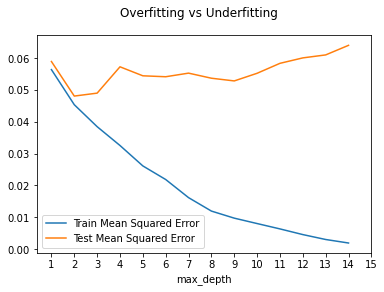

In [44]:
md_list = []
score_train_list = []
score_test_list = []
mse_train_list = []
mse_test_list = []

for maxdepth in list(range(1,15)):
  tree_model = DecisionTreeRegressor(random_state=0, max_depth=maxdepth)
  tree_model.fit(X_train, y_train)

  pred_train = tree_model.predict(X_train)
  pred_test = tree_model.predict(X_test)

  # Lists generation
  md_list.append(maxdepth)
  score_train_list.append(100.0*tree_model.score(X_train, y_train))
  score_test_list.append(100.0*tree_model.score(X_test, y_test))
  mse_train_list.append(mean_squared_error(y_train, pred_train))
  mse_test_list.append(mean_squared_error(y_test, pred_test))

df_maxdepth = pd.DataFrame({"max_depth":md_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list,
                   "mse_train":mse_train_list,
                   "mse_test":mse_test_list
                   })
df_maxdepth.set_index("max_depth", inplace=True)

df_maxdepth["mse_train"].plot(label="Train Mean Squared Error")
df_maxdepth["mse_test"].plot(label="Test Mean Squared Error")
plt.xticks(range(1,16))
plt.suptitle("Overfitting vs Underfitting")
plt.legend()
plt.show()

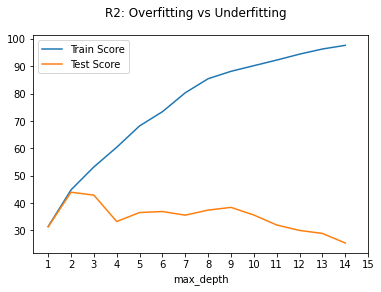

In [45]:
df_maxdepth["score_train"].plot(label="Train Score")
df_maxdepth["score_test"].plot(label="Test Score")
plt.suptitle("R2: Overfitting vs Underfitting")
plt.xticks(range(1,16))
plt.legend()
plt.show();

In [46]:
#AD with max_depth = 2:

tree_model = DecisionTreeRegressor(random_state=0, max_depth=2)
tree_model.fit(X_train, y_train)

score_train = "{:.2f}%".format(tree_model.score(X_train, y_train)*100.00)
score_test = "{:.2f}%".format(tree_model.score(X_test, y_test)*100.00)
mse_train = "{:.2f}".format(mean_squared_error(y_train, tree_model.predict(X_train)))
mse_test = "{:.2f}".format(mean_squared_error(y_test, tree_model.predict(X_test)))

print("Train score: ",score_train)
print("Test score: ",score_test)

models_overview = pd.DataFrame([["Decission Tree",score_train, score_test, mse_train, mse_test]],\
    columns=["Model","Train Score","Test Score","MSE Train", "MSE Test"])

Train score:  44.82%
Test score:  43.96%


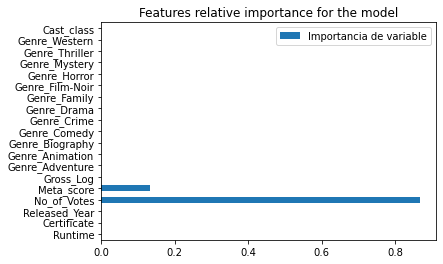

In [47]:
df_AD_imp = pd.DataFrame(tree_model.feature_importances_.reshape(1,-1), columns=X_train.columns, index=["Importancia de variable"])
df_AD_imp.T.plot.barh()
plt.legend()
plt.title("Features relative importance for the model")
plt.show()

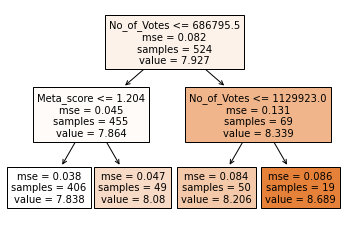

In [48]:
plot_tree(tree_model, filled=True, max_depth=10, feature_names=X_train.columns, class_names=["Y"] , fontsize=10)
plt.show()

In [49]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
Y_pred = xgb_model.predict(X_test)
score_train = xgb_model.score(X_train, y_train)
score_train = "{:.2f}%".format(score_train*100)
print('Training Score:', score_train)
score_test = xgb_model.score(X_test, y_test)
score_test = "{:.2f}%".format(score_test*100)
print('Testing Score:',  score_test)
output = pd.DataFrame({'Predicted':Y_pred})

mse_train = "{:.2f}".format(mean_squared_error(y_train, xgb_model.predict(X_train)))
mse_test = "{:.2f}".format(mean_squared_error(y_test, xgb_model.predict(X_test)))

models_overview.loc[len(models_overview),:] = ["XGBoost", score_train,\
    score_test, mse_train, mse_test ]

Training Score: 99.96%
Testing Score: 55.87%


In [50]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators=1050)
random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_test)

mae = mean_absolute_error(y_test.values.ravel(), Y_pred)
mse_train = "{:.2f}".format(mean_squared_error(y_train.values.ravel(), random_forest.predict(X_train)))
mse_test = "{:.2f}".format(mean_squared_error(y_test.values.ravel(), Y_pred))
r2 = r2_score(y_test.values.ravel(), Y_pred)
score_train = format(random_forest.score(X_train, y_train),'.2%')
score_test = format(random_forest.score(X_test, y_test),'.2%')

# Print metrics
print('Mean Absolute Error:', round(mae, 2))
print('Mean Squared Error:', mse_test)
print('R-squared:', round(r2, 2))
print('Train score: ', score_train)
print('Test score: ', format(random_forest.score(X_test, y_test.values.ravel()),'.2%'))


models_overview.loc[len(models_overview),:] = ["Random Forest", score_train,\
    score_test, mse_train, mse_test ]

Mean Absolute Error: 0.15
Mean Squared Error: 0.04
R-squared: 0.59
Train score:  94.87%
Test score:  58.81%


In [51]:
models_overview

,Model,Train Score,Test Score,MSE Train,MSE Test
0,Decission Tree,44.82%,43.96%,0.05,0.05
1,XGBoost,99.96%,55.87%,0.00,0.04
2,Random Forest,94.87%,58.81%,0.00,0.04


## Conclusions and prediction example

Out of the model overview, the model that has the best performance is the Random Forest regressor. Nonetheless, the score can be enhaced through further feature engineering and addition of new variables to the model. 

With the given model, I will:

1) Create a function that performs all the feature engineering performed previously, so that the predictions can be performed more easily for new data points.

2) Perform some prediction examples.

In [60]:
random_forest.predict(np.array(processed_final.loc[580,list(X_train.columns)]).reshape(1,-1))

array([7.88371429])

In [63]:
raw_df.loc[580,:]

Poster_Link        https://m.media-amazon.com/images/M/MV5BMTYxMj...
Series_Title                                   Manchester by the Sea
Released_Year                                                 2016.0
Certificate                                                      2.0
Runtime                                                          137
Genre                                                          Drama
IMDB_Rating                                                      7.8
Overview           A depressed uncle is asked to take care of his...
Meta_score                                                      96.0
Director                                            Kenneth Lonergan
Star1                                                  Casey Affleck
Star2                                              Michelle Williams
Star3                                                  Kyle Chandler
Star4                                                   Lucas Hedges
No_of_Votes                       